In [1]:
"""
The MIT License (MIT)
Copyright (c) 2021 NVIDIA
Permission is hereby granted, free of charge, to any person obtaining a copy of
this software and associated documentation files (the "Software"), to deal in
the Software without restriction, including without limitation the rights to
use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
the Software, and to permit persons to whom the Software is furnished to do so,
subject to the following conditions:
The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.
THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.
"""


'\nThe MIT License (MIT)\nCopyright (c) 2021 NVIDIA\nPermission is hereby granted, free of charge, to any person obtaining a copy of\nthis software and associated documentation files (the "Software"), to deal in\nthe Software without restriction, including without limitation the rights to\nuse, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of\nthe Software, and to permit persons to whom the Software is furnished to do so,\nsubject to the following conditions:\nThe above copyright notice and this permission notice shall be included in all\ncopies or substantial portions of the Software.\nTHE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR\nIMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS\nFOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR\nCOPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER\nIN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OU

This code example demonstrates how an autoencoder can be used for outlier detection. We do this by first training an autoencoder on the Modified National Institute of Standards and Technology (MNIST) dataset. Then we observe how the error is higher when the network is presented with an image that does not represent a handwritten digit. More context for this code example can be found in the section "Programming Example: Autoencoder for outlier detection" in Chapter 17 in the book Learning Deep Learning by Magnus Ekman (ISBN: 9780137470358).


We start with a set of import statements, followed by loading the MNIST dataset. However, in this example we do not standardize the data. The reason is worth some discussion. The task for the autoencoder is to reproduce the input on its outputs. This implies that we need to define the input data and the output unit of the network in a way that makes this possible. For example, if we use input data centered around 0, and a logistic sigmoid as the output unit, then the network simply cannot solve the problem because the logistic sigmoid can output only positive values. When working with image data, we want the output range to be bounded to a range of valid values (typically integer values between 0 and 255 or floating-point values between 0 and 1). A common way to ensure this is to scale the input values to be between 0 and 1 and use a logistic sigmoid unit as output unit. Another alternative would be to center the input around 0 and use a linear output unit, but we would then need to postprocess the output data to ensure that they do not contain out-of-range values. In our case, we decided to work with input values between 0 and 1, and it turns out that this is the default range for MNIST in PyTorch. Therefore we do not need to scale the values.


In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
EPOCHS = 10
BATCH_SIZE = 64

# Load MNIST dataset. In PyTorch it is in the range 0.0 - 1.0 so no need to
# rescale in this application.
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = MNIST(root='./pt_data', train=True, download=True, transform=transform)
testset = MNIST(root='./pt_data', train=False, download=True, transform=transform)


100%|██████████| 9912422/9912422 [00:00<00:00, 61512358.84it/s]


Extracting ./pt_data/MNIST/raw/train-images-idx3-ubyte.gz to ./pt_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 77651085.78it/s]

Extracting ./pt_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./pt_data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 19972251.52it/s]


Extracting ./pt_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./pt_data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 11559786.87it/s]

Extracting ./pt_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./pt_data/MNIST/raw



The next step is to define the model. This is shown in the code snippet below. The encoder part of the model consists of a Flatten layer (changing the dimension from 28×28 to 784) followed by a single fully connected (Dense) layer with 64 units. The decoder consists of another fully connected layer with 784 units, followed by a Reshape layer that changes the dimension from 784 to 28×28. That is, the decoder performs the inverse of the operations done by the encoder. The goal for the autoencoder is to generate an output image that is identical to the input image, and it has to do that by fully encoding the 28×28 (784) image in the intermediate representation vector of size 64.

We should point out that although we use fully connected layers for both the encoder and decoder in this example, when working with images, it is more common to use convolutional layers and some form of convolution-based upsampling layers. A detailed description of this can be found in Appendix B, but we use fully connected layers in this example to keep things simple and because it is feasible when working with the small and simple images from MNIST.


In [3]:
# Create autoencoder model.
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 64),
    nn.ReLU(),
    nn.Linear(64, 784),
    nn.Sigmoid(),
    nn.Unflatten(1, torch.Size([28, 28]))
)

# Create loss function and optimizer.
optimizer = torch.optim.Adam(model.parameters())
loss_function = nn.BCELoss()


The next step is to train the autoencoder. We need to tweak our training loop so it uses the same data as both input and target values so we cannot use our train_model function. Looking at the code below, you can see how we discard the target values from the trainloader and testloader and set both the inputs and targets to the same value. We also modify the dimensionality of the data by calling the squeeze() method. This results in removing any dimension of value 1. We had to do this in order to make the targets match the exact dimensionality of the model output. There is a pitfall to be aware of when doing this. If you would change the mini-batch size to 1, then this call would eliminate the dimension representing the mini-batch and things would break.

The rest of the training loop is unchanged compared to previous examples.


In [4]:
# Training loop for autoencoder.

# Transfer model to GPU.
model.to(device)

# Create dataloaders.
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

for i in range(EPOCHS):
    model.train() # Set model in training mode
    train_loss = 0.0
    train_absolute_error = 0.0
    train_batches = 0
    for inputs, _ in trainloader:
        # Move data to GPU. Use same value for input and target because
        # we are training an auto-encoder.
        inputs = inputs.squeeze() # Needed to remove redundant dimension in inputs
        inputs, targets = inputs.to(device), inputs.to(device)

        # Zero the parameter gradients.
        optimizer.zero_grad()

        # Forward pass.
        outputs = model(inputs)
        loss = loss_function(outputs, targets)

        # Accumulate metrics.
        train_absolute_error += (targets - outputs.data).abs().sum().item()
        train_batches +=  1
        train_loss += loss.item()

        # Backward pass and update.
        loss.backward()
        optimizer.step()

    train_loss = train_loss / train_batches
    train_mae = train_absolute_error / (train_batches * BATCH_SIZE)

    # Evaluate the model on the test dataset.
    model.eval() # Set model in inference mode.
    test_loss = 0.0
    test_absolute_error = 0.0
    test_batches = 0
    for inputs, _ in testloader:
        # Use same value for input and target because we are training
        # an auto-encoder.
        inputs = inputs.squeeze()
        inputs, targets = inputs.to(device), inputs.to(device)
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        test_absolute_error += (targets - outputs.data).abs().sum().item()
        test_batches += 1
        test_loss += loss.item()
    test_loss = test_loss / test_batches
    test_mae = test_absolute_error / (test_batches * BATCH_SIZE)
    print(f'Epoch {i+1}/{EPOCHS} loss: {train_loss:.4f} - mae: {train_mae:0.4f} - val_loss: {test_loss:.4f} - val_mae: {test_mae:0.4f}')


Epoch 1/10 loss: 0.1752 - mae: 73.6291 - val_loss: 0.1176 - val_mae: 41.8851
Epoch 2/10 loss: 0.1037 - mae: 33.9317 - val_loss: 0.0918 - val_mae: 27.0173
Epoch 3/10 loss: 0.0878 - mae: 24.2997 - val_loss: 0.0829 - val_mae: 21.2449
Epoch 4/10 loss: 0.0820 - mae: 20.4287 - val_loss: 0.0798 - val_mae: 19.0167
Epoch 5/10 loss: 0.0798 - mae: 18.8610 - val_loss: 0.0784 - val_mae: 18.0002
Epoch 6/10 loss: 0.0789 - mae: 18.2554 - val_loss: 0.0779 - val_mae: 17.6777
Epoch 7/10 loss: 0.0785 - mae: 17.9708 - val_loss: 0.0777 - val_mae: 17.4695
Epoch 8/10 loss: 0.0783 - mae: 17.8029 - val_loss: 0.0777 - val_mae: 17.5080
Epoch 9/10 loss: 0.0781 - mae: 17.6924 - val_loss: 0.0773 - val_mae: 17.2746
Epoch 10/10 loss: 0.0780 - mae: 17.6169 - val_loss: 0.0772 - val_mae: 17.2079


Next, we use the trained model to try to reproduce the images in the test dataset. After applying the model to all test images, we plot one of the test images next to its corresponding version produced by the network. The result should indicate that the network has learned to reproduce images of handwritten digits.


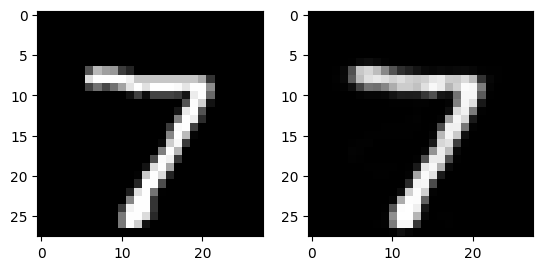

In [5]:
# Predict on test dataset.
testloader = DataLoader(dataset=testset, batch_size=10000, shuffle=False)
test_images, _ = next(iter(testloader))
test_images = test_images.to(device)
predict_images = model(test_images)

test_images = test_images.squeeze().cpu().numpy()
predict_images = predict_images.cpu().detach().numpy()

# Plot one input example and resulting prediction.
plt.subplot(1, 2, 1)
plt.imshow(test_images[0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.subplot(1, 2, 2)
plt.imshow(predict_images[0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()


The next step is to apply our autoencoder to a different image. We use a different dataset known as Fashion MNIST. This dataset is designed to serve as a drop-in replacement for MNIST. It consists of the same number of training and test images, using the same 28×28 resolution. Just as for MNIST, each image belongs to one of ten classes. The difference compared to MNIST is that instead of depicting handwritten images, the images depict various pieces of clothing: dress, shirt, sneaker, and so on. The code snippet below loads this dataset and uses the trained model to try to reproduce the fashion MNIST test images.

100%|██████████| 26421880/26421880 [00:01<00:00, 17329433.34it/s]


Extracting ./pt_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./pt_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 303206.29it/s]


Extracting ./pt_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./pt_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5499290.96it/s]


Extracting ./pt_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./pt_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 3349717.19it/s]


Extracting ./pt_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./pt_data/FashionMNIST/raw



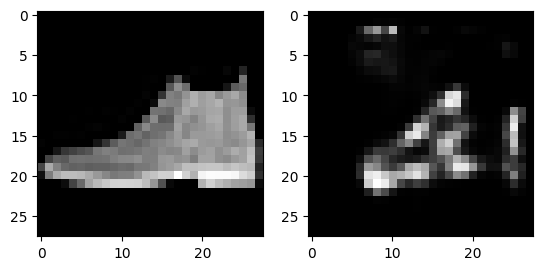

In [6]:
# Load Fashion-MNIST dataset.
transform = transforms.Compose(
    [transforms.ToTensor()])

f_trainset = FashionMNIST(root='./pt_data', train=True, download=True, transform=transform)
f_testset = FashionMNIST(root='./pt_data', train=False, download=True, transform=transform)

# Predict and plot.
testloader = DataLoader(dataset=f_testset, batch_size=10000, shuffle=False)
f_test_images, _ = next(iter(testloader))
f_test_images = f_test_images.to(device)
f_predict_images = model(f_test_images)
f_test_images = f_test_images.squeeze().cpu().numpy()

f_predict_images = f_predict_images.cpu().detach().numpy()
plt.subplot(1, 2, 1)
plt.imshow(f_test_images[0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.subplot(1, 2, 2)
plt.imshow(f_predict_images[0].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()


The result should indicate that the autoencoder is not good at reproducing images that look vastly different from the MNIST images. To quantify this further, the code snippet below computes the mean absolute error for the autoencoder, both for all MNIST test examples and all Fashion MNIST test examples. We then plot the results. The resulting chart shows how the autoencoder can be used to identify images that look different than the ones in the training dataset. The images that result in high error are generally from the Fashion MNIST dataset.


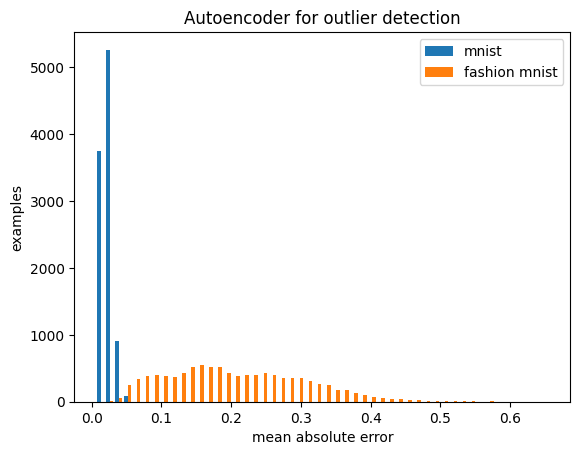

In [7]:
# Compute errors and plot.
error = np.mean(np.abs(test_images - predict_images), (1, 2))
f_error = np.mean(np.abs(f_test_images - f_predict_images), (1, 2))
_ = plt.hist((error, f_error), bins=50, label=['mnist',
                                               'fashion mnist'])
plt.legend()
plt.xlabel('mean absolute error')
plt.ylabel('examples')
plt.title("Autoencoder for outlier detection")
plt.show()


The chart indicates that there is some overlap between the two datasets in terms of resulting error. The code snippet below provides some insight into why this is the case by plotting the images with the highest error from the MNIST dataset.

See figures 17-3, 17-4, 17-5, and 17-6 for results generated from a TensorFlow implementation of this code example. The surrounding text also discusses the results.


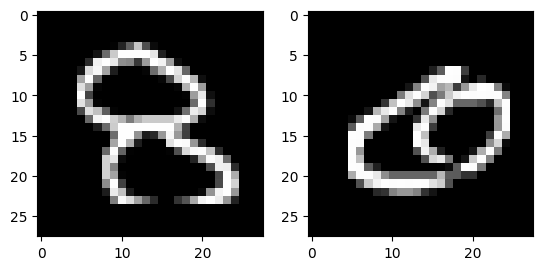

In [8]:
# Print outliers in mnist data.
index = error.argmax()
plt.subplot(1, 2, 1)
plt.imshow(test_images[index].reshape(28, 28), cmap=plt.get_cmap('gray'))
error[index] = 0
index = error.argmax()
plt.subplot(1, 2, 2)
plt.imshow(test_images[index].reshape(28, 28), cmap=plt.get_cmap('gray'))
plt.show()
